# InSitu Merge of data using Pandas
### Super fast mechanism for merging data (faster than you can write).

In [ ]:
BUCKET_NAME     = "ai-training-2024-08-09-bucket"
PROJECT_ID      = "ai-training-2024-08-09"
LOCATION        = "us-central1"
secret_name     = "ai-training-key-secret"
secret_version  = "latest"
project_id      = "usfs-tf-admin"
resource_name   = f"projects/{project_id}/secrets/{secret_name}/versions/{secret_version}"

In [ ]:
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#- Google Colab Check
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
RunningInCOLAB = False
RunningInCOLAB = 'google.colab' in str(get_ipython())

if RunningInCOLAB:
    print("You are running this notebook in Google Colab.")
else:
    print("You are running this notebook with Jupyter iPython runtime.")
    print("Assumption is you have the required libraries to execute this notebook.")

You are running this notebook in Google Colab.


In [ ]:
import sys
import subprocess
import importlib.util

In [ ]:
libraries=["numpy", "pandas", "scipy", "sklearn", "matplotlib", "xarray", "seaborn", "cartopy"]
import importlib.util

for library in libraries:
    if library == "Pillow":
      spec = importlib.util.find_spec("PIL")
    else:
      spec = importlib.util.find_spec(library)
    if spec is None:
      print("Installing library " + library)
      subprocess.run(["pip", "install" , library, "--quiet"])
    else:
      print("Library " + library + " already installed.")

Library numpy already installed.
Library pandas already installed.
Library scipy already installed.
Library sklearn already installed.
Library matplotlib already installed.
Library xarray already installed.
Library seaborn already installed.
Installing library cartopy


# Includes and Libraries

In [ ]:
############################################
#INCLUDES
############################################
import csv
from datetime import datetime, timedelta
import fnmatch
import statistics
import pickle

#number crunching
import numpy as np
import pandas as pd
import xarray as xr

#plotting
import matplotlib as matplt
import matplotlib.pyplot as plt
import seaborn as sns

#a set of libraries that perhaps should always be in Python source
import os
import datetime
import sys
import gc
import getopt
import inspect
import math
import warnings

# Pull in Library Functions

In [ ]:
#!rm -rf ./folderOnColab && echo "Ok, removed." || { echo "No folder to remove."; exit 1; }
#!mkdir -p ./folderOnColab && echo "Folder created." || { echo "Failed to create folder, it might already exist.";  }
#!gsutil -m cp -r gs://usfs-gcp-rand-test-data-usc1/public_source/jbooks/ANewHope.txt ./folderOnColab

target_folder="./folderOnColab"
target_repo="https://raw.githubusercontent.com//christophergarthwood/jbooks/main"
target_files=["support_debug.ipynb", "support_functions.ipynb"]
print(f"Creating a folder ({target_folder}) to store project data.")
subprocess.run(["mkdir", "-p" , target_folder])
if os.path.isdir(target_folder):
  print("Performing wget on:")
  for idx, filename in enumerate(target_files):
    print(f"...{filename} to target folder: {target_folder}")
    try:
      subprocess.run(["wget", f"--directory-prefix={target_folder}", f"{target_repo}/{filename}"])
    except Exception as e:
      print("")
      print(f"ERROR: There was a problem performing wget on the target file ({filename}), see Exception: {str(e)}")
      print("...talk to the instructor.")
    if os.path.isfile(target_folder+os.sep+filename):
      print("...verified copy.")
      print("...importing code.")
      target_filename=f"{target_folder+os.sep+filename}"
      os.environ["target_filename"]=target_filename
      %run $target_filename
    else:
      print(f"...copy NOT verified, check the {target_folder} for the existence of {filename}")
else:
    print("ERROR: Local folder not found/created.  Check the output to ensure your folder is created.")
    print(f"...target folder: {target_folder}")
    print("...if you can't find the problem contact the instructor.")


Creating a folder (./folderOnColab) to store project data.
Performing wget on:
...support_debug.ipynb to target folder: ./folderOnColab
...verified copy.
...importing code.
...support_functions.ipynb to target folder: ./folderOnColab
...verified copy.
...importing code.


# Setup Library Configuration for Numpy and Pandas

In [ ]:
msg_info("Setting Library Configuration")
set_library_configuration()

[2024-08-27 17:52:44 UTC]    INFO: Setting Library Configuration 


INFO:msg_logs:Setting Library Configuration


# Variable declaration

In [ ]:
############################################
#GLOBAL VARIABLES
############################################
DEBUG = 1
DEBUG_DATA = 1
SRC_DIR="./folderOnColab"

DEBUG = 1
DEBUG_DATA = 0

# CODE CONSTRAINTS
VERSION_NAME    = "InSitu-Flow-Thru"
VERSION_MAJOR   = 0
VERSION_MINOR   = 0
VERSION_RELEASE = 1

#used for values outside standard ASCII, just do it, you'll need it
ENCODING  ="utf-8"
############################################
# GLOBAL CONFIGURATION
############################################
os.environ['PYTHONIOENCODING']=ENCODING

#define ACS data setup
ACS_FILE="ACS.txt"
ACS_HEADER=["%Year","Month","Day","Hour","Minute","Second(UTC)","Longitude(deg)","Latitude(deg)","Pressure(dbar)","C400","C404.1","C407.1","C410.5","C413.9","C417.4","C421.5","C426","C430.1","C433.8","C437.9","C442.1","C446.3","C451.1","C455.7","C459.9","C464.1","C468.5","C473.3","C478","C483.1","C487.6","C491.8","C496","C500.1","C504.8","C509.5","C514.4","C519.2","C523.9","C528.2","C532.3","C536.6","C540.9","C545.4","C549.9","C554.3","C558.7","C563.2","C567.6","C571.5","C575.4","C579.3","C582.9","C587.6","C591.7","C596","C600.6","C605","C609.3","C613.9","C618.4","C622.5","C626.5","C630.9","C635","C639.3","C643.6","C647.9","C652.7","C657","C661.4","C665.9","C670.3","C674.7","C678.8","C683.2","C687.1","C690.8","C694.7","C698.9","C702.3","C706.3","C710","C714.2","C717.6","C721.4","C725.6","C729.2","C732.7","C735.9","C739.4","C743.7","A398.4","A402.1","A405.7","A408.9","A412.3","A415.8","A419.8","A424","A428.3","A432.2","A436.1","A440.3","A444.8","A449.5","A454.1","A458.3","A462.4","A466.8","A471.5","A476.4","A481.3","A486","A490.2","A494.4","A498.8","A503.1","A507.8","A512.6","A517.7","A522.5","A526.8","A531.1","A535.3","A539.7","A544.2","A548.7","A553.1","A557.5","A562.2","A566.6","A570.8","A574.6","A578.6","A582","A585.8","A589.6","A594","A598.7","A602.9","A607.6","A611.8","A616.5","A620.9","A625.2","A629.4","A633.7","A637.7","A642.1","A646.4","A650.9","A655.4","A660","A664.7","A669","A673.6","A677.8","A682","A685.9","A690","A693.7","A697.9","A701.7","A705.4","A709.2","A713.4","A717.1","A720.8","A724.6","A728.6","A732.1","A735.6","A738.9","A742.7"]
ACS_HEADER_COUNT=len(ACS_HEADER)
ACS_DOMAIN=ACS_HEADER[9:]

#define seabird data setup
SEB_FILE="SBE49_PTCS.txt"
SEB_HEADER=["Year","Month","Day","Hour","Minute","Second","Longitude","Latitude","Pressure(dbar)","Temperature(C)","Conductivity(S/m)","Salinity"]
SEB_HEADER_COUNT=len(SEB_HEADER)
SEB_DOMAIN=SEB_HEADER[8:]

SRC_DATETIME_FORMAT="%m/%d/%Y %H:%M:%S"
OPT_DT_FMT="%Y%m%d:%H%M%S"

#Output header
OTO_HEADER="%Year,Month,Day,Hour,Minute,Second,Longitude,Latitude,Pressure(dbar),Temperature(C),Conductivity(S/m),Salinity,ACS_Pressure,C400,C404.1,C407.1,C410.5,C413.9,C417.4,C421.5,C426,C430.1,C433.8,C437.9,C442.1,C446.3,C451.1,C455.7,C459.9,C464.1,C468.5,C473.3,C478,C483.1,C487.6,C491.8,C496,C500.1,C504.8,C509.5,C514.4,C519.2,C523.9,C528.2,C532.3,C536.6,C540.9,C545.4,C549.9,C554.3,C558.7,C563.2,C567.6,C571.5,C575.4,C579.3,C582.9,C587.6,C591.7,C596,C600.6,C605,C609.3,C613.9,C618.4,C622.5,C626.5,C630.9,C635,C639.3,C643.6,C647.9,C652.7,C657,C661.4,C665.9,C670.3,C674.7,C678.8,C683.2,C687.1,C690.8,C694.7,C698.9,C702.3,C706.3,C710,C714.2,C717.6,C721.4,C725.6,C729.2,C732.7,C735.9,C739.4,C743.7,A398.4,A402.1,A405.7,A408.9,A412.3,A415.8,A419.8,A424,A428.3,A432.2,A436.1,A440.3,A444.8,A4,49.5,A454.1,A458.3,A462.4,A466.8,A471.5,A476.4,A481.3,A486,A490.2,A494.4,A498.8,A503.1,A507.8,A512.6,A517.7,A522.5,A526.8,A531.1,A535.3,A539.7,A544.2,A548.7,A553.1,A557.5,A562.2,A566.6,A570.8,A574.6,A578.6,A582,A585.8,A589.6,A594,A598.7,A602.9,A607.6,A611.8,A616.5,A620.9,A625.2,A629.4,A633.7,A637.7,A642.1,A646.4,A650.9,A655.4,A660,A664.7,A669,A673.6,A677.8,A682,A685.9,A690,A693.7,A697.9,A701.7,A705.4,A709.2,A713.4,A717.1,A720.8,A724.6,A728.6,A732.1,A735.6,A738.9,A742.7"

############################################
#APPLICATION VARIABLES
############################################

SRC_FILE_COARSE_RES=ACS_FILE
COARSE_HEADER=ACS_HEADER
COARSE_DOMAIN=ACS_DOMAIN

SRC_FILE_FINE_RES=SEB_FILE
FINE_HEADER=SEB_HEADER
FINE_DOMAIN=SEB_DOMAIN

TIME_DELTA=1
TARGET_FILE_1TM="one_to_many.csv"
TARGET_FILE_1T1="one_to_one.csv"

SRC_FILE_COARSE_RES=SRC_DIR + os.sep + ACS_FILE
SRC_FILE_FINE_RES=SRC_DIR + os.sep +  SEB_FILE


# Check Your Libraries

In [ ]:
msg_info("Library Diagnostics")
lib_diagnostics()

[2024-08-27 17:53:59 UTC]    INFO: Library Diagnostics 


INFO:msg_logs:Library Diagnostics


matplotlib                              #: 3.7.1               
numpy                                   #: 1.26.4              
pandas                                  #: 2.1.4               


# Data Read

Your you own method to pull in the data or default to the Google Storage method where we copy the files to a local location ./folderOnColab.

In [ ]:
#!rm -rf ./folderOnColab && echo "Ok, removed." || { echo "No folder to remove."; exit 1; }
#!mkdir -p ./folderOnColab && echo "Folder created." || { echo "Failed to create folder, it might already exist.";  }
#!gsutil -m cp -r gs://usfs-gcp-rand-test-data-usc1/public_source/jbooks/ANewHope.txt ./folderOnColab

target_folder="./folderOnColab"
target_files=[ACS_FILE, SEB_FILE]
print(f"Creating a folder ({target_folder}) to store project data.")
subprocess.run(["mkdir", "-p" , target_folder])
if os.path.isdir(target_folder):
  for idx, filename in enumerate(target_files):
    print(f"Copying {filename} to target folder: {target_folder}")
    subprocess.run(["gsutil", "-m" , "cp", "-r", f"gs://{BUCKET_NAME}/public_source/jbooks/{filename}",  target_folder], check=True)
else:
    print("ERROR: Local folder not found/created.  Check the output to ensure your folder is created.")
    print(f"...target folder: {target_folder}")
    print("...if you can't find the problem contact the instructor.")


Creating a folder (./folderOnColab) to store project data.
Copying ACS.txt to target folder: ./folderOnColab
Copying SBE49_PTCS.txt to target folder: ./folderOnColab


# Application Specific Function Definitions

In [ ]:
def load_coarse_data():

    df_coarse = pd.read_csv(SRC_FILE_COARSE_RES, sep="\t", index_col=False)
    df_coarse.reset_index(inplace=True)

    if DEBUG:
      msg_debug("Coarse Resolution data has:" + str(df_coarse.columns))
      msg_debug("    size:" + str(df_coarse.size))
      msg_debug("    shape:" + str(df_coarse.shape))
      msg_debug("    ndim:" + str(df_coarse.ndim))
      msg_debug("    column size:" + str(df_coarse.columns.size))
      #index added so you get an extra column
      msg_debug("df_coarse.columns.size-1: " + str(df_coarse.columns.size-1))
      msg_debug("expected: " + str(ACS_HEADER_COUNT))
      if ( (df_coarse.columns.size-1) == ACS_HEADER_COUNT):
          msg_debug("Expectations met.")
      else:
          msg_debug("Expectations not met, check your datafile, columns don't match.")
      msg_debug(str(df_coarse.describe()))
    return df_coarse

In [ ]:
def load_fine_data():

    df_fine = pd.read_csv(SRC_FILE_FINE_RES, sep="\s+")
    df_fine.reset_index(inplace=True)

    if DEBUG:
      msg_debug("Fine Resolution data has:" + str(df_fine.columns))
      msg_debug("    size:" + str(df_fine.size))
      msg_debug("    shape:" + str(df_fine.shape))
      msg_debug("    ndim:" + str(df_fine.ndim))
      msg_debug("    column size:" + str(df_fine.columns.size))
      #index added so you get an extra column
      msg_debug("df_fine.columns.size-1: " + str(df_fine.columns.size-1))
      msg_debug("expected: " + str(SEB_HEADER_COUNT))
      if ( (df_fine.columns.size - 1) == SEB_HEADER_COUNT ):
          msg_debug("Expectations met.")
      else:
          msg_debug("Expectations not met, check your datafile, columns don't match.")
      msg_debug(str(df_fine.describe()))
    return df_fine

In [ ]:
#load the data file and then display some results

df_coarse=load_coarse_data()

[2024-08-27 17:57:33 UTC]   DEBUG: Coarse Resolution data has:Index(['index', 'Year', 'Month', 'Day', 'Hour', 'Minute', 'Second(UTC)',
       'Longitude(deg)', 'Latitude(deg)', 'Pressure(dbar)',
       ...
       'A709.2', 'A713.4', 'A717.1', 'A720.8', 'A724.6', 'A728.6', 'A732.1',
       'A735.6', 'A738.9', 'A742.7'],
      dtype='object', length=176) 


DEBUG:msg_logs:Coarse Resolution data has:Index(['index', 'Year', 'Month', 'Day', 'Hour', 'Minute', 'Second(UTC)',
       'Longitude(deg)', 'Latitude(deg)', 'Pressure(dbar)',
       ...
       'A709.2', 'A713.4', 'A717.1', 'A720.8', 'A724.6', 'A728.6', 'A732.1',
       'A735.6', 'A738.9', 'A742.7'],
      dtype='object', length=176)


[2024-08-27 17:57:33 UTC]   DEBUG:     size:9476192 


DEBUG:msg_logs:    size:9476192


[2024-08-27 17:57:33 UTC]   DEBUG:     shape:(53842, 176) 


DEBUG:msg_logs:    shape:(53842, 176)


[2024-08-27 17:57:33 UTC]   DEBUG:     ndim:2 


DEBUG:msg_logs:    ndim:2


[2024-08-27 17:57:33 UTC]   DEBUG:     column size:176 


DEBUG:msg_logs:    column size:176


[2024-08-27 17:57:33 UTC]   DEBUG: df_coarse.columns.size-1: 175 


DEBUG:msg_logs:df_coarse.columns.size-1: 175


[2024-08-27 17:57:33 UTC]   DEBUG: expected: 175 


DEBUG:msg_logs:expected: 175


[2024-08-27 17:57:33 UTC]   DEBUG: Expectations met. 


DEBUG:msg_logs:Expectations met.


[2024-08-27 17:57:34 UTC]   DEBUG:            index       Year      Month        Day       Hour     Minute  \
count 53,842.... 53,842.... 53,842.... 53,842.... 53,842.... 53,842....   
mean  26,920.... 2,018.0000     7.0000    18.2623    11.2927    32.5779   
std   15,542....     0.0000     0.0000     0.4399     7.0079    18.2942   
min       0.0000 2,018.0000     7.0000    18.0000     0.0000     0.0000   
25%   13,460.... 2,018.0000     7.0000    18.0000     5.0000    16.0000   
50%   26,920.... 2,018.0000     7.0000    18.0000    11.0000    37.0000   
75%   40,380.... 2,018.0000     7.0000    19.0000    17.0000    49.0000   
max   53,841.... 2,018.0000     7.0000    19.0000    23.0000    59.0000   

       Second(UTC)  Longitude(deg)  Latitude(deg)  Pressure(dbar)  ...  \
count 53,842....   53,842....      53,842....     53,842....       ...   
mean     30.0578      82.3655          6.1460        48.0717       ...   
std      17.3214       0.1071          0.1378        31.2270       

DEBUG:msg_logs:           index       Year      Month        Day       Hour     Minute  \
count 53,842.... 53,842.... 53,842.... 53,842.... 53,842.... 53,842....   
mean  26,920.... 2,018.0000     7.0000    18.2623    11.2927    32.5779   
std   15,542....     0.0000     0.0000     0.4399     7.0079    18.2942   
min       0.0000 2,018.0000     7.0000    18.0000     0.0000     0.0000   
25%   13,460.... 2,018.0000     7.0000    18.0000     5.0000    16.0000   
50%   26,920.... 2,018.0000     7.0000    18.0000    11.0000    37.0000   
75%   40,380.... 2,018.0000     7.0000    19.0000    17.0000    49.0000   
max   53,841.... 2,018.0000     7.0000    19.0000    23.0000    59.0000   

       Second(UTC)  Longitude(deg)  Latitude(deg)  Pressure(dbar)  ...  \
count 53,842....   53,842....      53,842....     53,842....       ...   
mean     30.0578      82.3655          6.1460        48.0717       ...   
std      17.3214       0.1071          0.1378        31.2270       ...   
min       0.0

In [ ]:
#load the data file and then display some results
df_fine=load_fine_data()

[2024-08-27 17:57:41 UTC]   DEBUG: Fine Resolution data has:Index(['index', 'Year', 'Month', 'Day', 'Hour', 'Minute', 'Second',
       'Longitude', 'Latitude', 'Pressure(dbar)', 'Temperature(C)',
       'Conductivity(S/m)', 'Salinity'],
      dtype='object') 


DEBUG:msg_logs:Fine Resolution data has:Index(['index', 'Year', 'Month', 'Day', 'Hour', 'Minute', 'Second',
       'Longitude', 'Latitude', 'Pressure(dbar)', 'Temperature(C)',
       'Conductivity(S/m)', 'Salinity'],
      dtype='object')


[2024-08-27 17:57:41 UTC]   DEBUG:     size:1259739 


DEBUG:msg_logs:    size:1259739


[2024-08-27 17:57:41 UTC]   DEBUG:     shape:(96903, 13) 


DEBUG:msg_logs:    shape:(96903, 13)


[2024-08-27 17:57:41 UTC]   DEBUG:     ndim:2 


DEBUG:msg_logs:    ndim:2


[2024-08-27 17:57:41 UTC]   DEBUG:     column size:13 


DEBUG:msg_logs:    column size:13


[2024-08-27 17:57:41 UTC]   DEBUG: df_fine.columns.size-1: 12 


DEBUG:msg_logs:df_fine.columns.size-1: 12


[2024-08-27 17:57:41 UTC]   DEBUG: expected: 12 


DEBUG:msg_logs:expected: 12


[2024-08-27 17:57:41 UTC]   DEBUG: Expectations met. 


DEBUG:msg_logs:Expectations met.


[2024-08-27 17:57:41 UTC]   DEBUG:            index       Year      Month        Day       Hour     Minute  \
count 96,903.... 96,903.... 96,903.... 96,903.... 96,903.... 96,903....   
mean  48,451.... 2,018.0000     7.0000    18.2404    10.7426    29.4979   
std   27,973....     0.0000     0.0000     0.4273     6.8948    17.3445   
min       0.0000 2,018.0000     7.0000    18.0000     0.0000     0.0000   
25%   24,225.... 2,018.0000     7.0000    18.0000     5.0000    14.0000   
50%   48,451.... 2,018.0000     7.0000    18.0000    10.0000    29.0000   
75%   72,676.... 2,018.0000     7.0000    18.0000    17.0000    45.0000   
max   96,902.... 2,018.0000     7.0000    19.0000    23.0000    59.0000   

          Second  Longitude   Latitude  Pressure(dbar)  Temperature(C)  \
count 96,903.... 96,903.... 96,903.... 87,719....      87,719....        
mean     29.4994    82.3793     6.1543    46.8047         24.7994        
std      17.3182     0.1104     0.1367    31.9070          2.8153  

DEBUG:msg_logs:           index       Year      Month        Day       Hour     Minute  \
count 96,903.... 96,903.... 96,903.... 96,903.... 96,903.... 96,903....   
mean  48,451.... 2,018.0000     7.0000    18.2404    10.7426    29.4979   
std   27,973....     0.0000     0.0000     0.4273     6.8948    17.3445   
min       0.0000 2,018.0000     7.0000    18.0000     0.0000     0.0000   
25%   24,225.... 2,018.0000     7.0000    18.0000     5.0000    14.0000   
50%   48,451.... 2,018.0000     7.0000    18.0000    10.0000    29.0000   
75%   72,676.... 2,018.0000     7.0000    18.0000    17.0000    45.0000   
max   96,902.... 2,018.0000     7.0000    19.0000    23.0000    59.0000   

          Second  Longitude   Latitude  Pressure(dbar)  Temperature(C)  \
count 96,903.... 96,903.... 96,903.... 87,719....      87,719....        
mean     29.4994    82.3793     6.1543    46.8047         24.7994        
std      17.3182     0.1104     0.1367    31.9070          2.8153        
min       0.0

# Data Preparation Example
### This is a way to ensure you get the data in the specific format you want.
### Notice the lambda expressions, used to execute a for loop in a single line and optimized for Pandas for fastest execution.
### Lambda expressions below are used to create a "time" field since the coarse data (Sea Bird) had fields discretely split out

In [ ]:
############################################
#COARSE DATA TIME/DATE Preparation
############################################
df_coarse['Month']    = df_coarse['Month'].astype(int).astype(str)
df_coarse['Day']      = df_coarse['Day'].astype(int).astype(str)
df_coarse['Year']     = df_coarse['Year'].astype(int).astype(str)
df_coarse['Hour']     = df_coarse['Hour'].astype(int).astype(str)
df_coarse['Minute']   = df_coarse['Minute'].astype(int).astype(str)
df_coarse['Seconds']   = df_coarse['Second(UTC)'].astype(int).astype(str)
df_coarse['Second']   = df_coarse['Second(UTC)'].astype(int).astype(str)
df_coarse['Date_Cal'] = df_coarse[['Year','Month','Day']].apply(lambda x: '/'.join(x), axis=1)
df_coarse['Date_Time']= df_coarse[['Hour','Minute','Second']].apply(lambda x: ':'.join(x), axis=1)
df_coarse['Date']     = df_coarse[['Date_Cal','Date_Time']].apply(lambda x: ' '.join(x), axis=1)
df_coarse.drop(columns=['Month','Day','Year','Hour','Minute','Second(UTC)','Second','Date_Cal','Date_Time'], inplace=True)

In [ ]:
#another example of a display option, Learn Pandas!
df_coarse.head()

,index,Longitude(deg),Latitude(deg),Pressure(dbar),C400,C404.1,C407.1,C410.5,C413.9,C417.4,...,A717.1,A720.8,A724.6,A728.6,A732.1,A735.6,A738.9,A742.7,Seconds,Date
0,0,82.5004,6.3881,56.6742,0.3842,0.3790,0.3553,0.3232,0.3223,0.2925,...,0.0206,0.0237,0.0262,0.0273,0.0265,0.0275,0.0308,0.0328,55,2018/7...
1,1,82.5004,6.3881,56.7638,0.3727,0.3607,0.3435,0.3376,0.3235,0.3080,...,0.0157,0.0194,0.0232,0.0283,0.0309,0.0310,0.0321,0.0303,56,2018/7...
2,2,82.5004,6.3880,56.8605,0.2946,0.3047,0.3036,0.3045,0.3032,0.2952,...,0.0160,0.0110,0.0071,0.0076,0.0059,0.0073,0.0073,0.0047,57,2018/7...
3,3,82.5004,6.3880,56.9583,0.3509,0.3119,0.3212,0.2961,0.2877,0.2790,...,0.0210,0.0222,0.0236,0.0315,0.0339,0.0283,0.0262,0.0233,58,2018/7...
4,4,82.5004,6.3880,57.0568,0.3575,0.3344,0.3338,0.3253,0.3347,0.3223,...,0.0127,0.0109,0.0107,0.0121,0.0140,0.0156,0.0147,0.0199,59,2018/7...


In [ ]:
#Learn Pandas, let's look at the head of the data, do we know what we have?
df_fine.head()

,index,Year,Month,Day,Hour,Minute,Second,Longitude,Latitude,Pressure(dbar),Temperature(C),Conductivity(S/m),Salinity
0,0,2018,7,18,3,33,10,82.5126,6.4125,0.3520,27.9873,5.4853,34.0471
1,1,2018,7,18,3,33,11,82.5126,6.4125,0.2779,27.9861,5.4852,34.0472
2,2,2018,7,18,3,33,12,82.5126,6.4125,0.3581,27.9863,5.4852,34.0472
3,3,2018,7,18,3,33,13,82.5126,6.4125,0.5248,27.9887,5.4854,34.0467
4,4,2018,7,18,3,33,14,82.5126,6.4125,0.5125,27.9870,5.4853,34.0471


In [ ]:
############################################
#FINE DATA TIME/DATE Preparation
############################################
df_fine['Month']    = df_fine['Month'].astype(int).astype(str)
df_fine['Day']      = df_fine['Day'].astype(int).astype(str)
df_fine['Year']    = df_fine['Year'].astype(int).astype(str)
df_fine['Hour']     = df_fine['Hour'].astype(int).astype(str)
df_fine['Minute']   = df_fine['Minute'].astype(int).astype(str)
df_fine['Second']   = df_fine['Second'].astype(int).astype(str)
df_fine['Date_Cal'] = df_fine[['Year','Month','Day']].apply(lambda x: '/'.join(x), axis=1)
df_fine['Date_Time']= df_fine[['Hour','Minute','Second']].apply(lambda x: ':'.join(x), axis=1)
df_fine['Date']     = df_fine[['Date_Cal','Date_Time']].apply(lambda x: ' '.join(x), axis=1)
df_fine.drop(columns=['Month','Day','Year','Hour','Minute','Second','Date_Cal','Date_Time'], inplace=True)

# Is the datastructure as expected?

In [ ]:
df_coarse['Date']=pd.to_datetime(df_coarse['Date'])
msg_debug("Coarse Resolution data has:" + str(df_coarse.columns))
msg_debug(df_coarse.info())
print(df_coarse.head())

[2024-08-27 17:58:09 UTC]   DEBUG: Coarse Resolution data has:Index(['index', 'Longitude(deg)', 'Latitude(deg)', 'Pressure(dbar)', 'C400',
       'C404.1', 'C407.1', 'C410.5', 'C413.9', 'C417.4',
       ...
       'A717.1', 'A720.8', 'A724.6', 'A728.6', 'A732.1', 'A735.6', 'A738.9',
       'A742.7', 'Seconds', 'Date'],
      dtype='object', length=172) 


DEBUG:msg_logs:Coarse Resolution data has:Index(['index', 'Longitude(deg)', 'Latitude(deg)', 'Pressure(dbar)', 'C400',
       'C404.1', 'C407.1', 'C410.5', 'C413.9', 'C417.4',
       ...
       'A717.1', 'A720.8', 'A724.6', 'A728.6', 'A732.1', 'A735.6', 'A738.9',
       'A742.7', 'Seconds', 'Date'],
      dtype='object', length=172)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53842 entries, 0 to 53841
Columns: 172 entries, index to Date
dtypes: datetime64[ns](1), float64(169), int64(1), object(1)
memory usage: 70.7+ MB
[2024-08-27 17:58:09 UTC]   DEBUG: None 


DEBUG:msg_logs:None


   index  Longitude(deg)  Latitude(deg)  Pressure(dbar)   C400  C404.1  \
0      0    82.5004          6.3881        56.6742      0.3842  0.3790   
1      1    82.5004          6.3881        56.7638      0.3727  0.3607   
2      2    82.5004          6.3880        56.8605      0.2946  0.3047   
3      3    82.5004          6.3880        56.9583      0.3509  0.3119   
4      4    82.5004          6.3880        57.0568      0.3575  0.3344   

   C407.1  C410.5  C413.9  C417.4  ...  A717.1  A720.8  A724.6  A728.6  \
0  0.3553  0.3232  0.3223  0.2925  ...  0.0206  0.0237  0.0262  0.0273   
1  0.3435  0.3376  0.3235  0.3080  ...  0.0157  0.0194  0.0232  0.0283   
2  0.3036  0.3045  0.3032  0.2952  ...  0.0160  0.0110  0.0071  0.0076   
3  0.3212  0.2961  0.2877  0.2790  ...  0.0210  0.0222  0.0236  0.0315   
4  0.3338  0.3253  0.3347  0.3223  ...  0.0127  0.0109  0.0107  0.0121   

   A732.1  A735.6  A738.9  A742.7  Seconds       Date  
0  0.0265  0.0275  0.0308  0.0328       55 2018-07... 

In [ ]:
df_fine['Date']=pd.to_datetime(df_fine['Date'])
msg_debug("Fine Resolution data has:" + str(df_fine.columns))
msg_debug(df_fine.info())
print(df_fine.head())

[2024-08-27 17:58:25 UTC]   DEBUG: Fine Resolution data has:Index(['index', 'Longitude', 'Latitude', 'Pressure(dbar)', 'Temperature(C)',
       'Conductivity(S/m)', 'Salinity', 'Date'],
      dtype='object') 


DEBUG:msg_logs:Fine Resolution data has:Index(['index', 'Longitude', 'Latitude', 'Pressure(dbar)', 'Temperature(C)',
       'Conductivity(S/m)', 'Salinity', 'Date'],
      dtype='object')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96903 entries, 0 to 96902
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   index              96903 non-null  int64         
 1   Longitude          96903 non-null  float64       
 2   Latitude           96903 non-null  float64       
 3   Pressure(dbar)     87719 non-null  float64       
 4   Temperature(C)     87719 non-null  float64       
 5   Conductivity(S/m)  87090 non-null  float64       
 6   Salinity           87090 non-null  float64       
 7   Date               96903 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 5.9 MB
[2024-08-27 17:58:25 UTC]   DEBUG: None 


DEBUG:msg_logs:None


   index  Longitude  Latitude  Pressure(dbar)  Temperature(C)  \
0      0    82.5126    6.4125     0.3520         27.9873        
1      1    82.5126    6.4125     0.2779         27.9861        
2      2    82.5126    6.4125     0.3581         27.9863        
3      3    82.5126    6.4125     0.5248         27.9887        
4      4    82.5126    6.4125     0.5125         27.9870        

   Conductivity(S/m)  Salinity       Date  
0     5.4853           34.0471 2018-07...  
1     5.4852           34.0472 2018-07...  
2     5.4852           34.0472 2018-07...  
3     5.4854           34.0467 2018-07...  
4     5.4853           34.0471 2018-07...  


# Panda's routines are optimized Cython (C Code) that is 100's of times faster than standard Python
### Merge to nearest neighbor within 1 second of each timestamp
### Merge on data

In [ ]:
############################################
#Merge Data
############################################
df=pd.merge_asof(df_coarse, df_fine, on="Date", tolerance=pd.Timedelta('1s'), direction="nearest")

In [ ]:
#yeah, it's that fast

In [ ]:
msg_debug("Coarse Resolution data size:"+str(df_coarse['Date'].size))
msg_debug("Fine Resolution data size:"+str(df_fine['Date'].size))
msg_debug("Resultant Resolution data size:"+str(df['Date'].size))

[2024-08-27 17:58:39 UTC]   DEBUG: Coarse Resolution data size:53842 


DEBUG:msg_logs:Coarse Resolution data size:53842


[2024-08-27 17:58:39 UTC]   DEBUG: Fine Resolution data size:96903 


DEBUG:msg_logs:Fine Resolution data size:96903


[2024-08-27 17:58:39 UTC]   DEBUG: Resultant Resolution data size:53842 


DEBUG:msg_logs:Resultant Resolution data size:53842


# Clean Merged Content
### Merging data has a cost, simple example of manipulating column names and data setup

In [ ]:
############################################
#COLUMN ARRANGEMENT & DATA MANIPULATION/TYPING
############################################

new_names=["index_x","ACS_Longitude","ACS_Latitude","ACS_Pressure","C400","C404.1","C407.1","C410.5","C413.9","C417.4","C421.5","C426","C430.1","C433.8","C437.9","C442.1","C446.3","C451.1","C455.7","C459.9","C464.1","C468.5","C473.3","C478","C483.1","C487.6","C491.8","C496","C500.1","C504.8","C509.5","C514.4","C519.2","C523.9","C528.2","C532.3","C536.6","C540.9","C545.4","C549.9","C554.3","C558.7","C563.2","C567.6","C571.5","C575.4","C579.3","C582.9","C587.6","C591.7","C596","C600.6","C605","C609.3","C613.9","C618.4","C622.5","C626.5","C630.9","C635","C639.3","C643.6","C647.9","C652.7","C657","C661.4","C665.9","C670.3","C674.7","C678.8","C683.2","C687.1","C690.8","C694.7","C698.9","C702.3","C706.3","C710","C714.2","C717.6","C721.4","C725.6","C729.2","C732.7","C735.9","C739.4","C743.7","A398.4","A402.1","A405.7","A408.9","A412.3","A415.8","A419.8","A424","A428.3","A432.2","A436.1","A440.3","A444.8","A449.5","A454.1","A458.3","A462.4","A466.8","A471.5","A476.4","A481.3","A486","A490.2","A494.4","A498.8","A503.1","A507.8","A512.6","A517.7","A522.5","A526.8","A531.1","A535.3","A539.7","A544.2","A548.7","A553.1","A557.5","A562.2","A566.6","A570.8","A574.6","A578.6","A582","A585.8","A589.6","A594","A598.7","A602.9","A607.6","A611.8","A616.5","A620.9","A625.2","A629.4","A633.7","A637.7","A642.1","A646.4","A650.9","A655.4","A660","A664.7","A669","A673.6","A677.8","A682","A685.9","A690","A693.7","A697.9","A701.7","A705.4","A709.2","A713.4","A717.1","A720.8","A724.6","A728.6","A732.1","A735.6","A738.9","A742.7","Seconds","Date","index_y","SBE_Longitude","SBE_Latitude","SBE_Pressure(dbar)","SBE_Temperature(C)","SBE_Conductivity(S/m)","SBE_Salinity"]
df.columns=new_names

In [ ]:
#CREATE A MILI-SECONDS COLUMN
df['MS'] = df.apply(lambda row: row.Date - df.loc[0,'Date'], axis=1)
df['Time(ms)'] = df['MS'].dt.total_seconds() / (24 * 60 * 60)

In [ ]:
df['Time(ms)']

,Time(ms)
0,0.0000
1,0.0000
2,0.0000
3,0.0000
4,0.0000
...,...
53837,1.1062
53838,1.1062
53839,1.1063
53840,1.1063


# Plotting
### Note the commented out code for saving the figure to the file system.

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

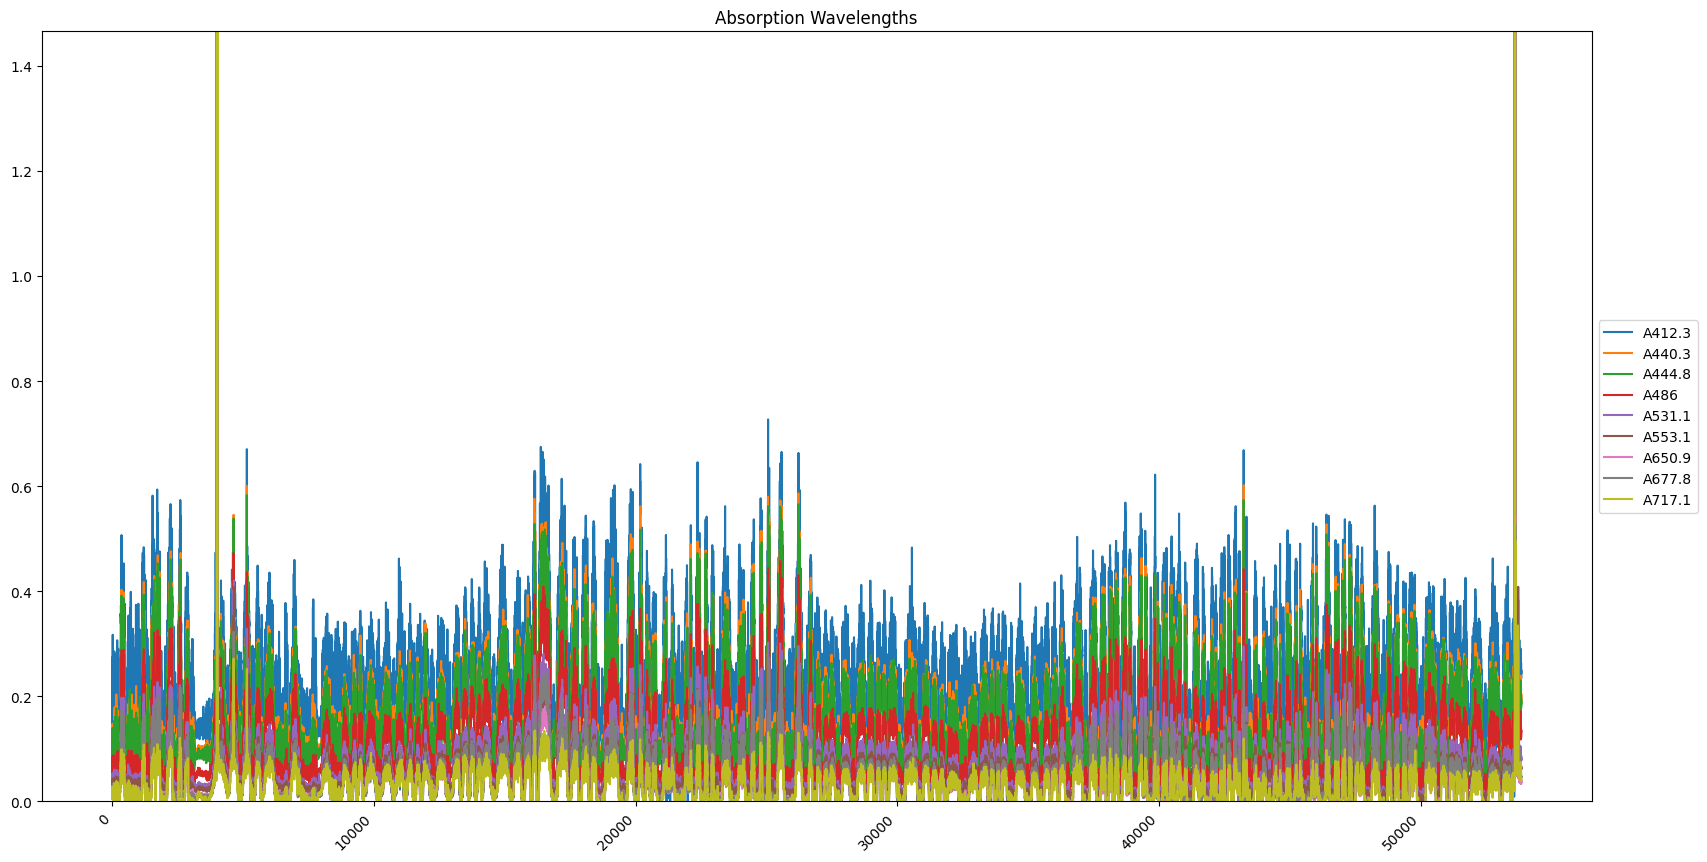

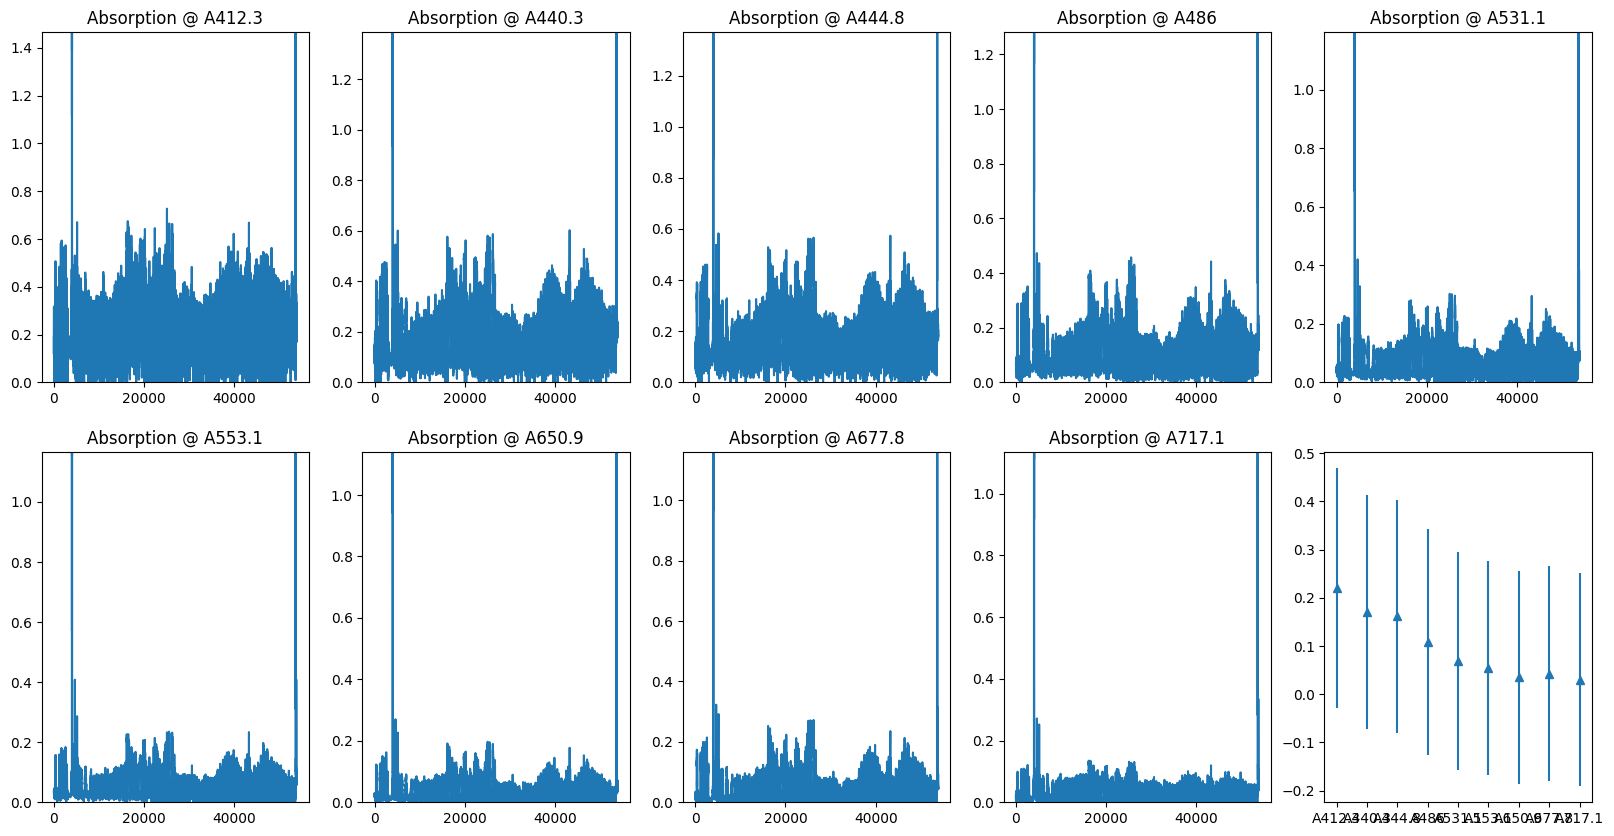

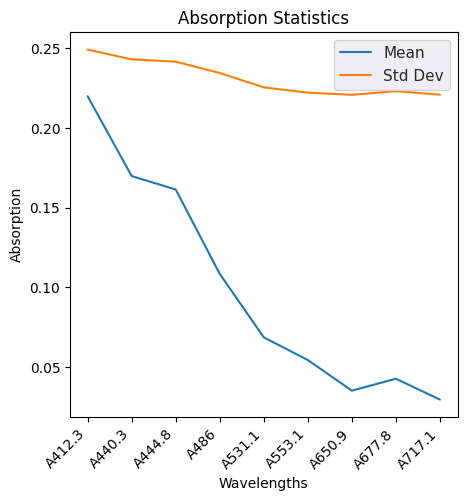

In [ ]:
############################################
#ABSORPTION PLOTS
############################################

#Plot along wavelengths showing individual values, all values, and some basic statistics
#Consider this a very basic approach to plotting
#this keeps the plot within the context of this notebook, else the plot will appear in a new window
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
spectra = ['A412.3','A440.3','A444.8','A486',  'A531.1','A553.1','A650.9','A677.8','A717.1']         #Absorption wavelengths in order, WAP doesn't output in order
c = ['C413.9','C442.1','C446.3','C487.6','C532.3','C554.3','C652.7','C674.7','C717.6']         #Beam Attenuation wavelengths in order, WAP doesn't output in order

df_columns=df.columns.values.tolist()
target_col_idx=[]
for val in spectra:
    target_col_idx.append(df_columns.index(val))


#constants
PLT_MAX_ROW=2
PLT_MAX_COL=5
PLT_X_SIZE=20
PLT_Y_SIZE=10
PLT_LGD_X_OFFSET=1
PLT_LGD_Y_OFFSET=0.5
PLT_Y_SCALE_STDDEV=5
row_index=0
col_index=0
y_range_limit=20

#statistics
spectra_means=df[df.columns[target_col_idx]].apply(np.mean)
spectra_std  =df[df.columns[target_col_idx]].apply(np.std)
spectra_mean_max=np.max(spectra_means)
spectra_std_max=np.max(spectra_std)
y_range_limit=spectra_mean_max + (spectra_std_max * PLT_Y_SCALE_STDDEV)

#initial fiture creating a 1 x 1 (default) # of plots in one page 20 x 10 in size (makes the plots larger)
fig, axes = plt.subplots(figsize=(PLT_X_SIZE, PLT_Y_SIZE))
ax=df[df.columns[target_col_idx]].plot(ax=axes)
ax.legend(loc='center left', bbox_to_anchor=(PLT_LGD_X_OFFSET,PLT_LGD_Y_OFFSET))
labels=ax.get_xticklabels()
plt.setp(labels,rotation=45,horizontalalignment='right')
ax.set_ylim(bottom=0,top=y_range_limit)
ax.set_title(label="Absorption Wavelengths")
ax.set_ylabel="Wavelength"
ax.set_xlabel="Time(s)"
#plt.savefig("./AbsoptionSpectraOverTime.png")
#plt.close()

#initial fiture creating a 2 x 5 # of plots in one page 20 x 10 in size (makes the plots larger)
fig, axes = plt.subplots(PLT_MAX_ROW, PLT_MAX_COL, figsize=(PLT_X_SIZE, PLT_Y_SIZE))
#iterate through the absorption array
for idx in target_col_idx:
    if ( col_index == (PLT_MAX_COL ) ):
        row_index +=1
        col_index = 0
    ax=df[df.columns[idx]].plot(ax=axes[row_index,col_index])
    #legend offset removed, not enough room in the plot screen
    #ax.legend(loc='center left', bbox_to_anchor=(PLT_LGD_X_OFFSET,PLT_LGD_Y_OFFSET))
    spectra_specific_mean=spectra_means[df.columns[idx]]
    spectra_specific_std=spectra_std[df.columns[idx]]
    y_range_limit=spectra_specific_mean + (spectra_specific_std * PLT_Y_SCALE_STDDEV)
    ax.set_ylim(bottom=0,top=y_range_limit)
    ax.set_title(label="Absorption @ " + df.columns[idx])
    ax.set_ylabel=""
    ax.set_xlabel="Time(s)"
    col_index+=1

#output the names of columns to a list; just an example
spectra_names=spectra

#plot the means as the last index in the 2x5 array of plots
plt.set_title='Absorption Means'
plt.setp(labels,rotation=45,horizontalalignment='right')
ax=plt.errorbar(df.columns[target_col_idx],spectra_means, spectra_std, linestyle='None', marker='^' )
#plt.savefig("./AbsoptionSpectraOverTimeSubPlots.png")
#plt.close()

#new figure using seaborn api which "knows" your data based on titles / names
import seaborn as sns
fig, axes = plt.subplots(figsize=(5,5))
sns.set(style="darkgrid")
ax=sns.lineplot(data=spectra_means, label="Mean")
ax=sns.lineplot(data=spectra_std, label="Std Dev")
ax.set_title("Absorption Statistics")
ax.set_ylabel("Absorption")
ax.set_xlabel("Wavelengths")
labels=ax.get_xticklabels()
plt.setp(labels,rotation=45,horizontalalignment='right')
#plt.savefig("./AbsoptionStats.png")
#plt.close()

# Now saving to file system.  Check your local directory for *.png's

In [ ]:
############################################
#BEAM ATTENUATION PLOTS
############################################

#Plot along wavelengths showing individual values, all values, and some basic statistics
#Consider this a very basic approach to plotting
#this keeps the plot within the context of this notebook, else the plot will appear in a new window
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
spectra = ['C413.9','C442.1','C446.3','C487.6','C532.3','C554.3','C652.7','C674.7','C717.6']         #Beam Attenuation wavelengths in order, WAP doesn't output in order

df_columns=df.columns.values.tolist()
target_col_idx=[]
for val in spectra:
    target_col_idx.append(df_columns.index(val))


#constants
PLT_MAX_ROW=2
PLT_MAX_COL=5
PLT_X_SIZE=20
PLT_Y_SIZE=10
PLT_LGD_X_OFFSET=1
PLT_LGD_Y_OFFSET=0.5
PLT_Y_SCALE_STDDEV=5
row_index=0
col_index=0
y_range_limit=20

#statistics
spectra_means=df[df.columns[target_col_idx]].apply(np.mean)
spectra_std  =df[df.columns[target_col_idx]].apply(np.std)
spectra_mean_max=np.max(spectra_means)
spectra_std_max=np.max(spectra_std)
y_range_limit=spectra_mean_max + (spectra_std_max * PLT_Y_SCALE_STDDEV)

#initial fiture creating a 1 x 1 (default) # of plots in one page 20 x 10 in size (makes the plots larger)
fig, axes = plt.subplots(figsize=(PLT_X_SIZE, PLT_Y_SIZE))
ax=df[df.columns[target_col_idx]].plot(ax=axes)
ax.legend(loc='center left', bbox_to_anchor=(PLT_LGD_X_OFFSET,PLT_LGD_Y_OFFSET))
labels=ax.get_xticklabels()
plt.setp(labels,rotation=45,horizontalalignment='right')
ax.set_ylim(bottom=0,top=y_range_limit)
ax.set_title(label="Beam Attenuation Wavelengths")
ax.set_ylabel="Wavelength"
ax.set_xlabel="Time(s)"
plt.savefig("./BeamCSpectraOverTime.png")
plt.close()


#initial fiture creating a 2 x 5 # of plots in one page 20 x 10 in size (makes the plots larger)
fig, axes = plt.subplots(PLT_MAX_ROW, PLT_MAX_COL, figsize=(PLT_X_SIZE, PLT_Y_SIZE))
#iterate through the absorption array
for idx in target_col_idx:
    if ( col_index == (PLT_MAX_COL ) ):
        row_index +=1
        col_index = 0
    ax=df[df.columns[idx]].plot(ax=axes[row_index,col_index])
    #legend offset removed, not enough room in the plot screen
    #ax.legend(loc='center left', bbox_to_anchor=(PLT_LGD_X_OFFSET,PLT_LGD_Y_OFFSET))
    spectra_specific_mean=spectra_means[df.columns[idx]]
    spectra_specific_std=spectra_std[df.columns[idx]]
    y_range_limit=spectra_specific_mean + (spectra_specific_std * PLT_Y_SCALE_STDDEV)
    ax.set_ylim(bottom=0,top=y_range_limit)
    ax.set_title(label="Beam Attenuation @ " + df.columns[idx])
    ax.set_ylabel=""
    ax.set_xlabel="Time(s)"
    col_index+=1

#output the names of columns to a list; just an example
spectra_names=spectra

#plot the means as the last index in the 2x5 array of plots
plt.set_title='Beam Attenuation'
plt.setp(labels,rotation=45,horizontalalignment='right')
ax=plt.errorbar(df.columns[target_col_idx],spectra_means, spectra_std, linestyle='None', marker='^' )
plt.savefig(target_folder+os.sep+"BeamCSpectraOverTimeSubPlots.png")
plt.close()

#new figure using seaborn api which "knows" your data based on titles / names
import seaborn as sns
fig, axes = plt.subplots(figsize=(5,5))
sns.set(style="darkgrid")
ax=sns.lineplot(data=spectra_means, label="Mean")
ax=sns.lineplot(data=spectra_std, label="Std Dev")
ax.set_title("Beam Attenuation Statistics")
ax.set_ylabel("Beam Attenuation")
ax.set_xlabel("Wavelengths")
labels=ax.get_xticklabels()
plt.setp(labels,rotation=45,horizontalalignment='right')
plt.savefig(target_folder+os.sep+"BeamCStats.png")
plt.close()

In [ ]:
sns.set(style="darkgrid")
marker_size=0.5

fig, axes = plt.subplots(figsize=(PLT_X_SIZE, PLT_Y_SIZE))
ax=sns.lineplot(data=df['SBE_Pressure(dbar)'], label="Depth")
ax.legend(loc='center left', bbox_to_anchor=(PLT_LGD_X_OFFSET,PLT_LGD_Y_OFFSET))
ax.set_title("Depth Over Time")
ax.set_ylabel("Depth")
ax.set_xlabel("Time")
labels=ax.get_xticklabels()
plt.setp(labels,rotation=45,horizontalalignment='right')
plt.savefig(target_folder+os.sep+"DepthOverTime.png")
plt.close()

# More data QA

TypeError: seaborn.utils._scatter_legend_artist() got multiple values for keyword argument 'label'

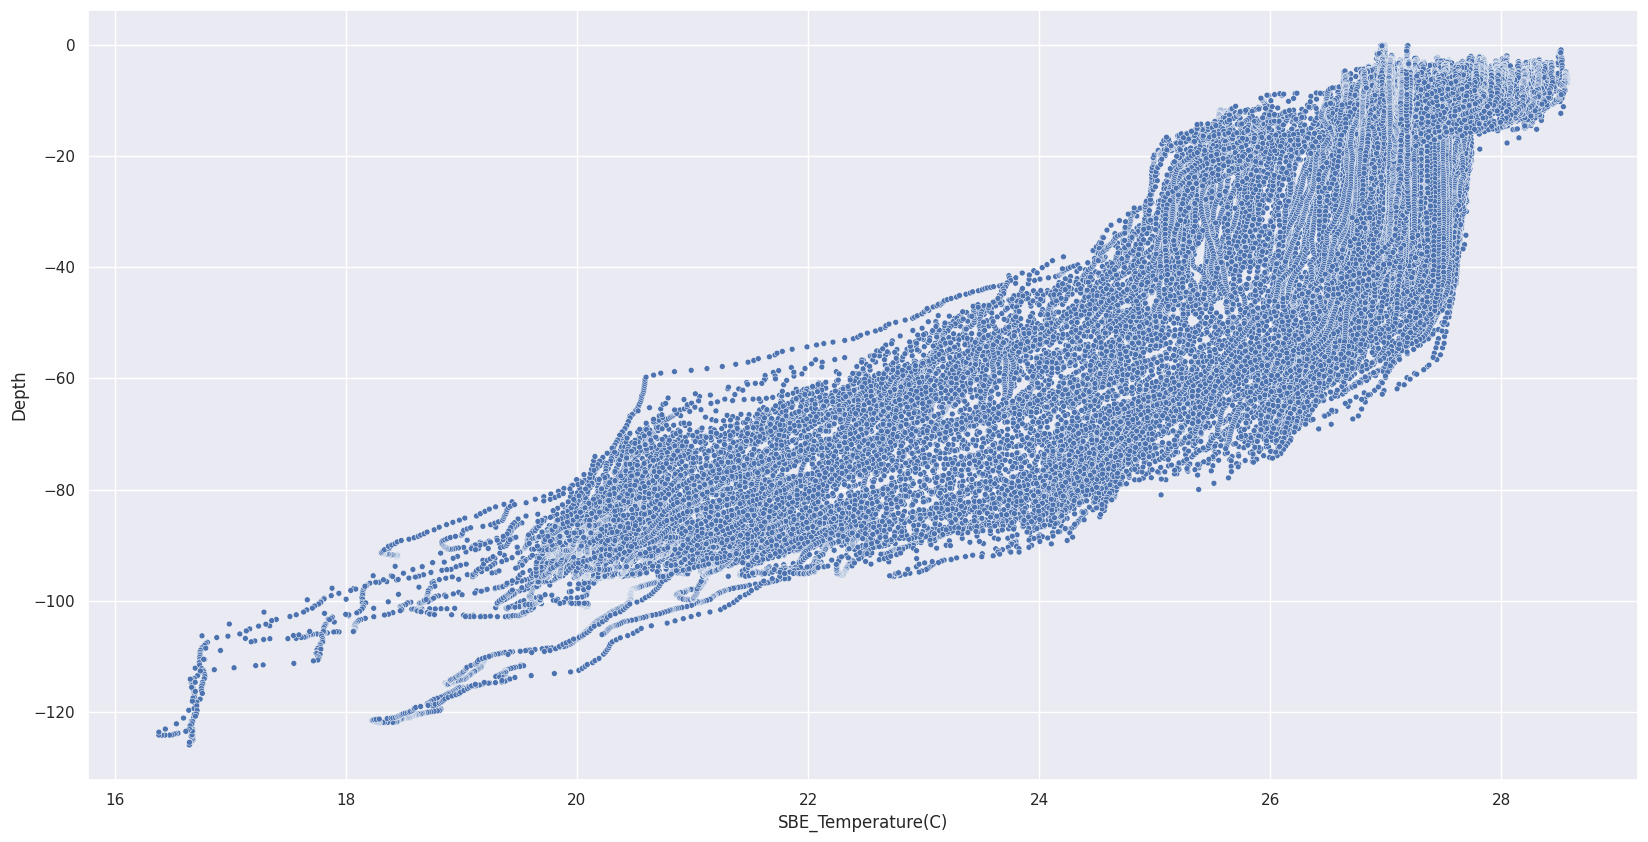

In [ ]:
fig, axes = plt.subplots(figsize=(PLT_X_SIZE, PLT_Y_SIZE))

df['Depth']=df['SBE_Pressure(dbar)'] * (-1.0)
depth_name='Depth'
ax=sns.scatterplot(y=df[depth_name],x=df['SBE_Temperature(C)'], label="Temp(C)",size=marker_size)
ax.set_title("Temp(C) over Time at Depth")
ax.set_ylabel("Depth")
ax.set_xlabel("Temp(C)")
#plt.savefig("./Temperature.png")
#plt.close()

fig, axes = plt.subplots(figsize=(PLT_X_SIZE, PLT_Y_SIZE))
ax=sns.scatterplot(y=df[depth_name],x=df['SBE_Salinity'], label="Salinity", size=marker_size)
ax.set_title("Salinity over Time at Depth")
ax.set_ylabel("Depth")
ax.set_xlabel("Salinity")
#plt.savefig(target_folder+os.sep+"Salinity.png")
#plt.close()

df.drop(columns='Depth', inplace=True)

# Do we know if the data is accurate?  Did the merge actually merge our values?

CRSError: Invalid projection: +proj=mill +a=6378137.0 +lon_0=<bound method Series.median of 0 82.5004 1 82.5004 2 82.5004 3 82.5004 4 82.5004 ... 53837 82.1788 53838 82.1788 53839 82.1787 53840 82.1787 53841 82.1787 Name: SBE_Longitude, Length: 53842, dtype: float64> +no_defs +type=crs: (Internal Proj Error: proj_create: invalid value for lon_0)

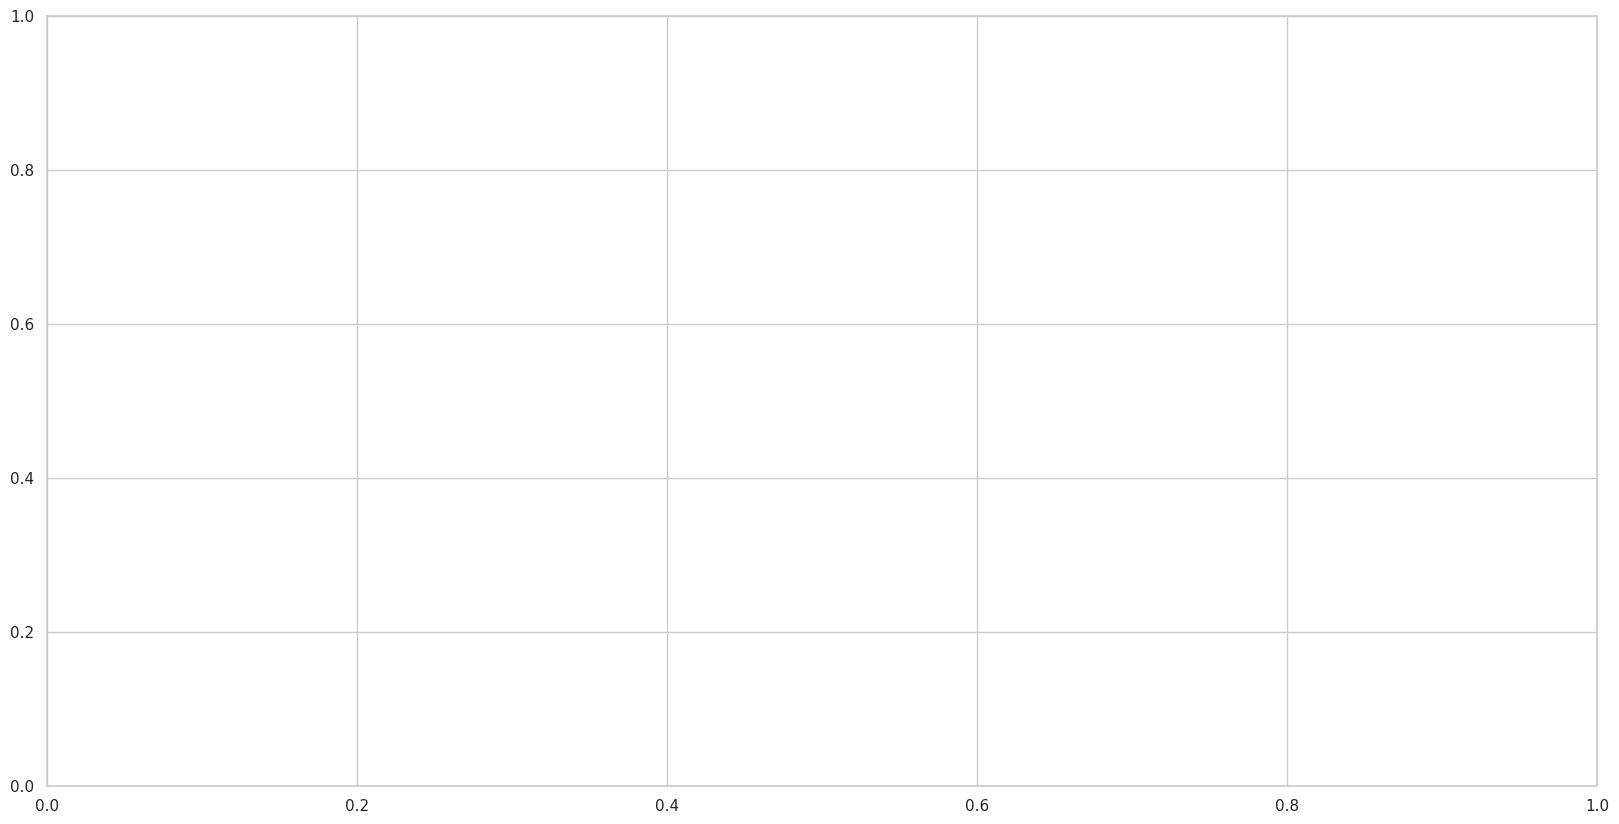

In [ ]:
#%matplotlib nbagg
import cartopy.crs as ccrs

sns.set_style("whitegrid")


TARGET_DATAFRAME=df
DIS_MDL_DF=df
DIS_SAT_DF=df

central_longitude=TARGET_DATAFRAME['SBE_Longitude'].median
central_latitude=TARGET_DATAFRAME['SBE_Latitude'].median
west=TARGET_DATAFRAME['SBE_Longitude'].min()   - 0.5
east=TARGET_DATAFRAME['SBE_Longitude'].max()   + 0.5
north=TARGET_DATAFRAME['SBE_Latitude'].max()  + 0.5
south=TARGET_DATAFRAME['SBE_Latitude'].min()  - 0.5

fig, axes = plt.subplots(figsize=(PLT_X_SIZE, PLT_Y_SIZE))
ax = fig.add_subplot(1, 1, 1,projection=ccrs.Miller(central_longitude=central_longitude))
ax.set_extent([west, east, south, north])
ax.coastlines()
#ax.stock_img()
ax.gridlines()
ax.add_wms(wms='http://vmap0.tiles.osgeo.org/wms/vmap0',layers=['basic'])

SAT_COLOR='red'
MDL_COLOR='blue'
SAT_SIZE=100.0
MDL_SIZE=0.01

ax.scatter(DIS_SAT_DF['SBE_Longitude'],DIS_SAT_DF['SBE_Latitude'],c=SAT_COLOR,s=SAT_SIZE, label='SBE Lat/Lon')
ax.scatter(DIS_SAT_DF['ACS_Longitude'],DIS_SAT_DF['ACS_Latitude'],c=MDL_COLOR,s=MDL_SIZE, label='ACS Lat/Lon')
plt.legend(loc='upper left');

ax.set_title("Shiptrack")
ax.set_ylabel("Latitude")
ax.set_xlabel("Longitude")
#plt.savefig("./ShipTrack.png")
#plt.close()
plt.show()

# Save your results

In [ ]:
#CREATE AN INITIAL "PROOF" OUTPUT for ANALYSIS
df.to_csv(target_folder+os.sep+"Initial_ACS_SBE_MergedProof.csv",index=False)

In [ ]:
#REARRANGE/TRIM COLUMNS TO SUPPORT WAP OUTPUT
df.drop(columns=['index_y','index_x','Seconds','Date','SBE_Conductivity(S/m)','ACS_Longitude','ACS_Latitude','ACS_Pressure'],inplace=True)

new_df=df.rename(index=str, columns={"Time(ms)": "UTC/GMT_Time","SBE_Longitude": "Longitude","SBE_Latitude": "Latitude","SBE_Salinity": "Salinity", "SBE_Temperature(C)": "Temp(C)"})
df=new_df
show_columns_plain(df.columns)
print("")

new_order=["Latitude","Longitude","UTC/GMT_Time","Temp(C)","Salinity","C400","C404.1","C407.1","C410.5","C413.9","C417.4","C421.5","C426","C430.1","C433.8","C437.9","C442.1","C446.3","C451.1","C455.7","C459.9","C464.1","C468.5","C473.3","C478","C483.1","C487.6","C491.8","C496","C500.1","C504.8","C509.5","C514.4","C519.2","C523.9","C528.2","C532.3","C536.6","C540.9","C545.4","C549.9","C554.3","C558.7","C563.2","C567.6","C571.5","C575.4","C579.3","C582.9","C587.6","C591.7","C596","C600.6","C605","C609.3","C613.9","C618.4","C622.5","C626.5","C630.9","C635","C639.3","C643.6","C647.9","C652.7","C657","C661.4","C665.9","C670.3","C674.7","C678.8","C683.2","C687.1","C690.8","C694.7","C698.9","C702.3","C706.3","C710","C714.2","C717.6","C721.4","C725.6","C729.2","C732.7","C735.9","C739.4","C743.7","A398.4","A402.1","A405.7","A408.9","A412.3","A415.8","A419.8","A424","A428.3","A432.2","A436.1","A440.3","A444.8","A449.5","A454.1","A458.3","A462.4","A466.8","A471.5","A476.4","A481.3","A486","A490.2","A494.4","A498.8","A503.1","A507.8","A512.6","A517.7","A522.5","A526.8","A531.1","A535.3","A539.7","A544.2","A548.7","A553.1","A557.5","A562.2","A566.6","A570.8","A574.6","A578.6","A582","A585.8","A589.6","A594","A598.7","A602.9","A607.6","A611.8","A616.5","A620.9","A625.2","A629.4","A633.7","A637.7","A642.1","A646.4","A650.9","A655.4","A660","A664.7","A669","A673.6","A677.8","A682","A685.9","A690","A693.7","A697.9","A701.7","A705.4","A709.2","A713.4","A717.1","A720.8","A724.6","A728.6","A732.1","A735.6","A738.9","A742.7","SBE_Pressure(dbar)"];
df=df[new_order]
print("")
df.head()

df['Salinity']=df['Salinity'].astype(float)
df['Temp(C)']=df['Temp(C)'].astype(float)
new_df=df.dropna()
df=new_df
df.head()

KeyError: "['index_y', 'index_x', 'Seconds', 'Date', 'SBE_Conductivity(S/m)', 'ACS_Longitude', 'ACS_Latitude', 'ACS_Pressure'] not found in axis"

In [ ]:
df.to_csv(target_folder+os.sep+"Final_ACS_SBE_Merged.csv",index=False, sep="\t")